<a href="https://colab.research.google.com/github/yoadeoye/Employee-Attrition/blob/main/Employee_Attrition_FE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('gdrive')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).



**FEATURE SELECTION & ENGINEERING**

In [ ]:
# loading the data from excel file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline 

data=pd.ExcelFile('/content/gdrive/MyDrive/Colab Notebooks/Employee Attrition.xlsx')
employeesLeft=data.parse('Employees who have left')
existingEmployees=data.parse('Existing employees')

# dropping duplicates in each dataset
employeesLeft.drop_duplicates(inplace=True)
existingEmployees.drop_duplicates(inplace=True)

#preprocess in each dataset - dropping the unique variables
X_full=employeesLeft.drop('Emp ID',axis=1)
X_test_full=existingEmployees.drop('Emp ID',axis=1)

# choosing the target variable and predictors
X=X_full.drop('satisfaction_level',axis=1)
y=employeesLeft.satisfaction_level

# testdata
X_test=X_test_full.drop('satisfaction_level',axis=1)

# splitting the training and validation data
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size=0.8,random_state=0)

#separating the categorical and numerical columns 
categorical_columns=[col for col in X_train.columns if X_train[col].dtypes=='object']
numerical_columns=[col for col in X_train.columns if X_train[col].dtypes in ['int64','float64']]

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
X_train_plus=X_train[categorical_columns].copy()
X_valid_plus=X_valid[categorical_columns].copy()

OE=OrdinalEncoder()
X_train[categorical_columns]=OE.fit_transform(X_train_plus)
X_valid[categorical_columns]=OE.transform(X_valid_plus)

# A function to measure dataset as regards preprocessing

def score_dataset(X_train=X_train,X_valid=X_valid,y_train=y_train,y_valid=y_valid):
  from sklearn.ensemble import RandomForestRegressor
  model=RandomForestRegressor(n_estimators=100,random_state=0).fit(X_train,y_train)
  preds=model.predict(X_valid)
  from sklearn.metrics import mean_absolute_error
  return mean_absolute_error(preds,y_valid)
print('The mae using Ordinal Encoding :'.title(),score_dataset(X_train,X_valid,y_train,y_valid))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

The Mae Using Ordinal Encoding : 0.04306212914812407


In [ ]:
# one-hot Encoding 
from sklearn.preprocessing import OneHotEncoder
X_train_dat=X_train[categorical_columns].copy()
X_valid_dat=X_valid[categorical_columns].copy()

OH=OneHotEncoder(handle_unknown='ignore',sparse=False)

OHX_train=pd.DataFrame(OH.fit_transform(X_train_dat))
OHX_valid=pd.DataFrame(OH.transform(X_valid_dat))

# one hot encoding removes the index : return it 
OHX_train.index=X_train_dat.index
OHX_valid.index=X_valid_dat.index

# getting the numerical columns
num_X_train=X_train.drop(categorical_columns,axis=1)
num_X_valid=X_valid.drop(categorical_columns,axis=1)

# combining the numerical and categorical data[after Onehotencoding]
OHX_train_total=pd.concat([OHX_train,num_X_train],axis=1)
OHX_valid_total=pd.concat([OHX_valid,num_X_valid],axis=1)

print('The mae using ONE HOT Encoding :'.title(),score_dataset(OHX_train_total,OHX_valid_total,y_train,y_valid))

The Mae Using One Hot Encoding : 0.04292285630948213


**INSIGHTS**
- Both preprocessing method performed well but OneHotEncoder shows the lowest mae thus we use pipeline for fewer and cleaner codes with less bugs

In [ ]:
# PIPELINING 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
categorical_columns
numerical_columns
numerical_transformer=SimpleImputer(strategy='constant')
categorical_transformer=Pipeline(steps=[('impute',SimpleImputer(strategy='most_frequent')),
                                        ('onehot',OneHotEncoder(handle_unknown='ignore',sparse=False)),
                                        
])

# bundle the transformers together 
preprocessor=ColumnTransformer(transformers=[('num',numerical_transformer,numerical_columns),
                                             ('cat',categorical_transformer,categorical_columns)])
    

# bundle the model and the preprocessoer
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor(n_estimators=100,random_state=0)

my_pipeline=Pipeline(steps=[('preprocessor',preprocessor),('model',model)])

my_pipeline.fit(X_train,y_train)
pipe_preds=my_pipeline.predict(X_valid)

from sklearn.metrics import mean_absolute_error
mean_absolute_error(pipe_preds,y_valid)

0.04274577328866443

In [ ]:
# lets test our model on different data as its preprocess and fits it automatically 
my_pipeline.predict(X_test)

array([0.4388, 0.438 , 0.3944, ..., 0.7387, 0.7168, 0.3032])

In [ ]:
result1=pd.DataFrame({'ID':X_valid.index,
                      'predictions':pipe_preds})
result2=pd.DataFrame({'ID_Xtest':X_test.index,
                      'new_data_prediction':my_pipeline.predict(X_test)})


In [ ]:
point=[]
for i in np.round(my_pipeline.predict(X_test),4):
  if i in np.round(pipe_preds,4):
    print
    point.append(i)

print('The no of benchmarking values :',len(point))
np.array(point).reshape(271,6)

The no of benchmarking values : 1626


array([[0.3944, 0.4809, 0.4161, 0.8197, 0.4447, 0.3998],
       [0.4254, 0.4087, 0.4032, 0.4283, 0.4245, 0.8234],
       [0.419 , 0.3867, 0.4092, 0.432 , 0.8427, 0.3887],
       ...,
       [0.3946, 0.4061, 0.3727, 0.8492, 0.4035, 0.4329],
       [0.8047, 0.3761, 0.3218, 0.404 , 0.4057, 0.4047],
       [0.4134, 0.7626, 0.3852, 0.8188, 0.6578, 0.8017]])

In [ ]:
# to compare and spool out the features of the employees data that will leave next
X_test_full['new_data_prediction']=np.round(my_pipeline.predict(X_test),2)
X_test_compared=X_test_full.copy()

In [ ]:
X_test_compared.head(2)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,dept,salary,new_data_prediction
0,0.58,0.74,4,215,3,0,0,sales,low,0.44
1,0.82,0.67,2,202,3,0,0,sales,low,0.44


In [ ]:
X_test_compared['Leaving/Not']=np.where(X_test_compared['satisfaction_level']==X_test_compared['new_data_prediction'],'Yes','No')

In [ ]:
employees_leaving_next=X_test_compared[X_test_compared['Leaving/Not'].values=='Yes']

In [ ]:
employees_leaving_next

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,dept,salary,new_data_prediction,Leaving/Not
192,0.64,0.58,5,115,5,0,0,support,low,0.64,Yes
273,0.63,0.93,4,201,3,0,0,IT,low,0.63,Yes
388,0.72,0.51,3,235,2,0,0,sales,low,0.72,Yes
524,0.65,0.67,5,128,5,0,0,marketing,medium,0.65,Yes
565,0.48,0.67,5,273,3,0,0,support,medium,0.48,Yes
...,...,...,...,...,...,...,...,...,...,...,...
10914,0.68,0.99,3,159,2,0,0,accounting,medium,0.68,Yes
11050,0.70,0.68,5,225,7,0,0,sales,medium,0.70,Yes
11171,0.79,0.86,5,238,8,0,0,sales,low,0.79,Yes
11185,0.73,0.78,3,262,7,1,1,management,high,0.73,Yes


In [ ]:
# determing which features are most important to our model
# install and import eli5
!pip install eli5

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
perm=PermutationImportance(my_pipeline,random_state=1).fit(X_valid,y_valid)
eli5.show_weights(perm,feature_names=X_valid.columns.tolist())

Weight,Feature
0.6851 ± 0.0335,number_project
0.5214 ± 0.0196,time_spend_company
0.4469 ± 0.0069,average_montly_hours
0.2404 ± 0.0112,last_evaluation
0.0018 ± 0.0018,dept
0.0001 ± 0.0001,Work_accident
0.0000 ± 0.0000,promotion_last_5years
-0.0002 ± 0.0009,salary


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


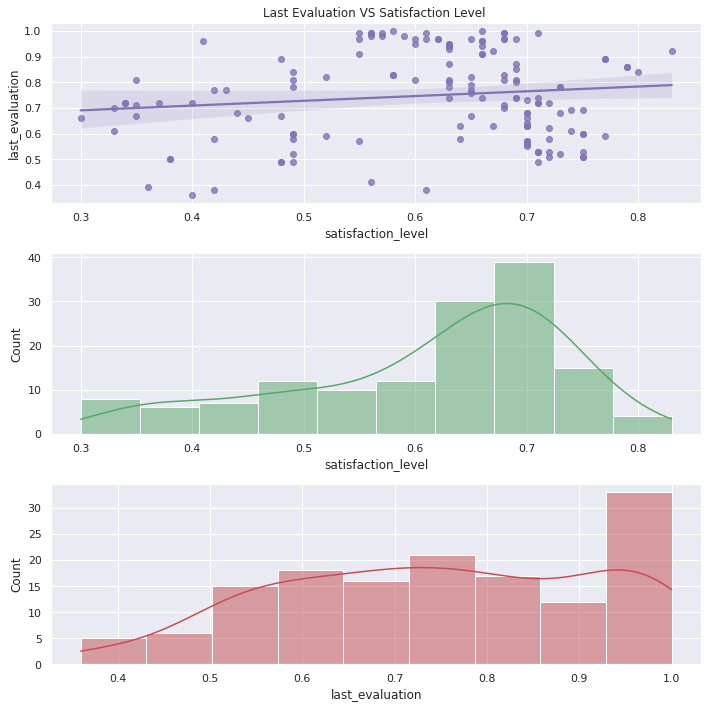

In [ ]:
# VISUALIZATIONS OF THE EXISTING-EMPLOYEES PREDICTED TO LEAVE SOONEST
sns.set()
plt.figure(figsize=[10,10])
ax=subplot(3,1,1)
sns.regplot(employees_leaving_next['satisfaction_level'],employees_leaving_next['last_evaluation'],color='m')
ax.set_title('Last Evaluation VS Satisfaction Level ')
ax=subplot(3,1,2)
sns.histplot(employees_leaving_next['satisfaction_level'],kde=True,color='g')
ax=subplot(3,1,3)
sns.histplot(employees_leaving_next['last_evaluation'],kde=True,color='r')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_de

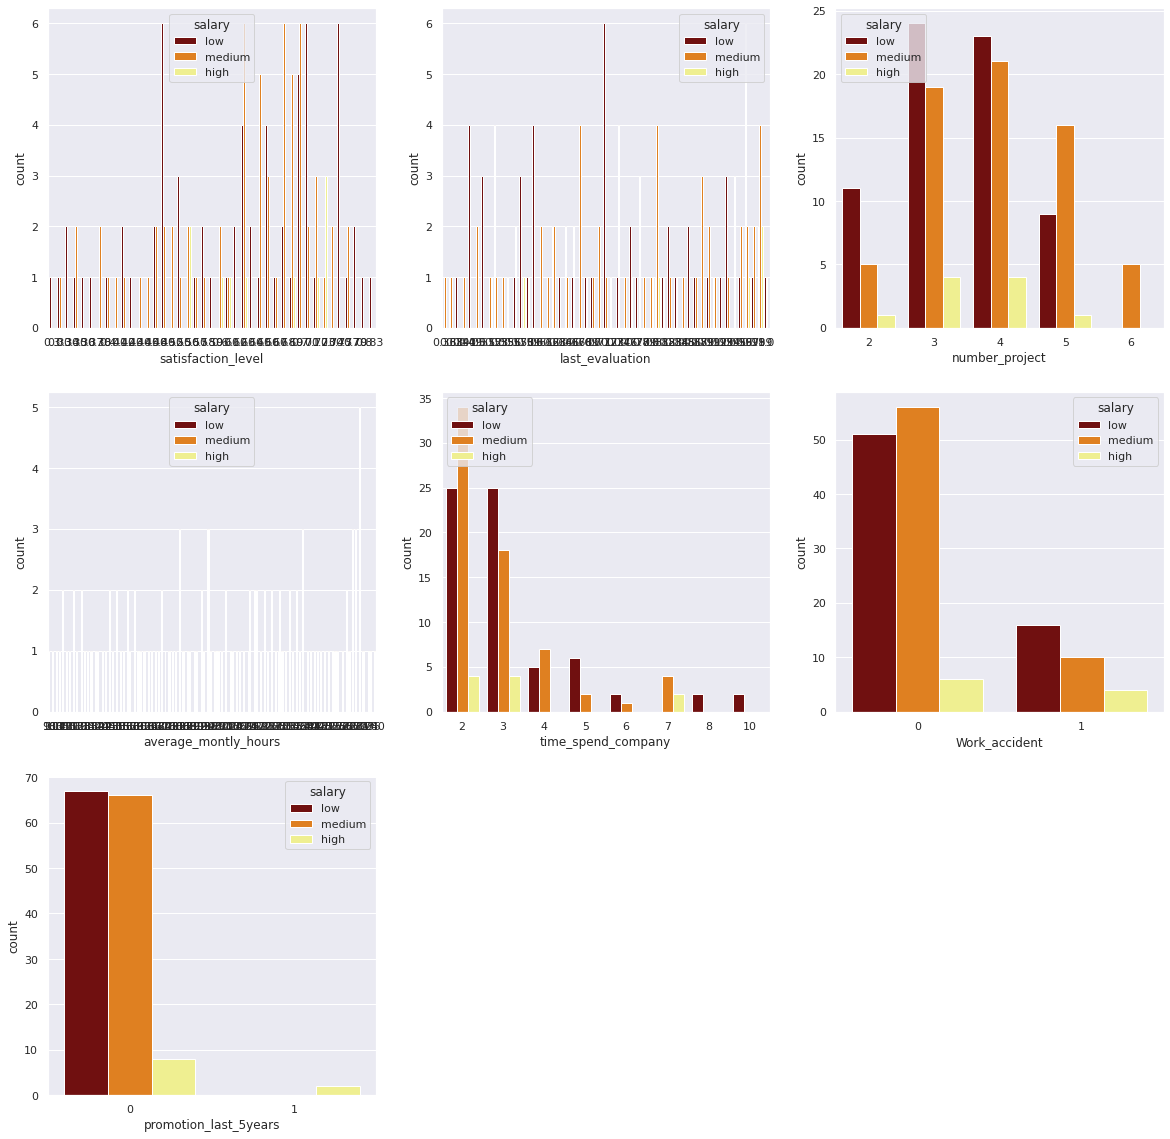

In [ ]:
num_data=employees_leaving_next.select_dtypes(exclude='object')
num_data.drop('new_data_prediction',axis=1,inplace=True)
plt.figure(figsize=[20,20])
sns.set()
for i,col in list(enumerate(num_data)):
  ax=plt.subplot(3,3,i+1)
  sns.countplot(num_data[col],hue=employees_leaving_next['salary'],palette='afmhot')

  plt.tight_layout
plt.show()

In [171]:
#storing the employees leaving next data in a csv file 
employees_leaving_next.to_csv('Employees Leaving Next.csv')